In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')

from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score
from sklearn.metrics import plot_confusion_matrix 
from sklearn.metrics import classification_report

import nltk
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.tokenize import WhitespaceTokenizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet

from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/utkarshgoyal/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Data Exploration

In [3]:
# loading data
df = pd.read_csv('./complaints.csv')
df.shape

/var/folders/sc/m38hzk_90cn6t0363cr74ny40000gn/T/ipykernel_2369/742255000.py:2: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('./complaints.csv')


(3553244, 18)

In [4]:
# Create a new dataframe with two columns
df1 = df[['Product', 'Consumer complaint narrative']].copy()

# Remove missing values (NaN)
df1 = df1[pd.notnull(df1['Consumer complaint narrative'])]

# Renaming second column for a simpler name
df1.columns = ['product', 'consumer_complaint'] 

df1.shape

(1281950, 2)

In [5]:
df2 = df1.sample(100000, random_state=1).copy()
df2.shape

(100000, 2)

In [6]:
df2.replace({'product': 
             {'Credit reporting, credit repair services, or other personal consumer reports': 
              'Credit reporting, repair, or other', 
              'Credit reporting': 'Credit reporting, repair, or other',
             'Credit card': 'Credit card or prepaid card',
             'Prepaid card': 'Credit card or prepaid card',
             'Payday loan': 'Payday loan, title loan, or personal loan',
             'Money transfer': 'Money transfer, virtual currency, or money service',
             'Virtual currency': 'Money transfer, virtual currency, or money service'}}, 
            inplace= True)

In [7]:
# Create a new column 'category_id' with encoded categories 
df2['category_id'] = df2['product'].factorize()[0]
category_id_df = df2[['product', 'category_id']].drop_duplicates()


# Dictionaries for future use
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'product']].values)

# New dataframe
df2.head()

,product,consumer_complaint,category_id
2769767,Credit card or prepaid card,It was brought to my attention by other people...,0
442490,"Credit reporting, repair, or other",I contacted Equfax 9 times to solve a credit r...,1
1021406,"Credit reporting, repair, or other",I am writing to dispute the account XXXX Accou...,1
2041703,"Credit reporting, repair, or other",Looked at a printed Experian copyPrevious empl...,1
2474865,Debt collection,I received this email on XX/XX/XXXX from Conve...,2


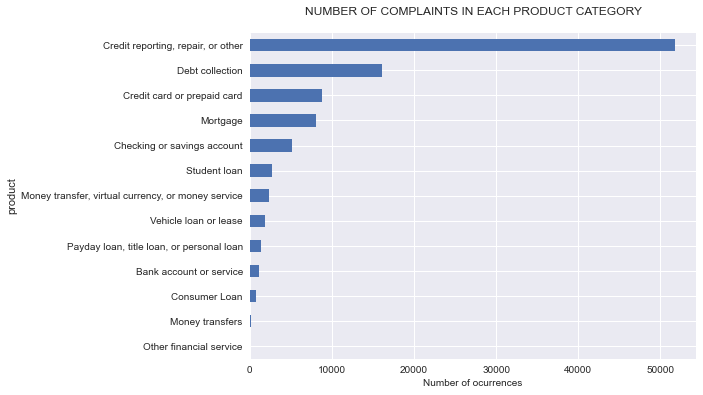

In [8]:
fig = plt.figure(figsize=(8,6))
df2.groupby('product').consumer_complaint.count().sort_values().plot.barh(ylim=0, 
                                                    title= 'NUMBER OF COMPLAINTS IN EACH PRODUCT CATEGORY\n')
plt.xlabel('Number of ocurrences', fontsize = 10);
plt.show()

In [9]:
import re

def remove_stopwords(input_text):
        stopwords_list = stopwords.words('english')
        # Some words which might indicate a certain sentiment are kept via a whitelist
        whitelist = ["n't", "not", "no"]
        words = input_text.split() 
        clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
        return " ".join(clean_words) 

def normalize(i):
#     for i in data:
    i = re.sub("(#[A-Za-z0-9]+)|(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)","",i)
    i = i.lower()
    # get rid of urls
    i = re.sub('https?://\S+|www\.\S+', '', i)
    i = re.sub('<[^>]*>', '', i)
    i = re.sub(r'[^\w\s]','', i)
    i = re.sub(r'\$\w*','', i)
    i = re.sub(r'^RT[\s]+','', i)
    i = re.sub(r'http\S+','', i)
    i = re.sub(r'#','', i)

    # get rid of non words and extra spaces
    i = re.sub('\\W', ' ', i)
    i = re.sub('\n', '', i)
    i = re.sub(' +', ' ', i)
    i = re.sub('^ ', '', i)
    i = re.sub(' $', '', i)
    
    return i

In [10]:
df2['consumer_complaint1'] = df2.consumer_complaint.apply(remove_stopwords)
df2['clean_review'] = df2['consumer_complaint1'].apply(normalize)

In [11]:
df2.head()

,product,consumer_complaint,category_id,consumer_complaint1,clean_review
2769767,Credit card or prepaid card,It was brought to my attention by other people...,0,It brought attention people Citibank overcharg...,it brought attention people citibank overcharg...
442490,"Credit reporting, repair, or other",I contacted Equfax 9 times to solve a credit r...,1,contacted Equfax times solve credit reporting ...,contacted equfax times solve credit reporting ...
1021406,"Credit reporting, repair, or other",I am writing to dispute the account XXXX Accou...,1,writing dispute account XXXX Account Number XX...,writing dispute account xxxx account number xx...
2041703,"Credit reporting, repair, or other",Looked at a printed Experian copyPrevious empl...,1,Looked printed Experian copyPrevious employer ...,looked printed experian copyprevious employer ...
2474865,Debt collection,I received this email on XX/XX/XXXX from Conve...,2,received email XX/XX/XXXX Convergent Outsourci...,received email xxxxxxxx convergent outsourcing...


# TFIDF

In [12]:
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

In [13]:
porter = PorterStemmer()

def tokenizer_porter(text):
    return [porter.stem(word) for word in text.split()]

In [14]:
tfidf = TfidfVectorizer(strip_accents=None,
                        lowercase=False,
                        preprocessor=None,
                        tokenizer=tokenizer_porter,
                        use_idf=True,
                        norm='l2', smooth_idf=True)

X = tfidf.fit_transform(df2['clean_review'])
y = df2['category_id'].values

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

## Random Forest

In [16]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [17]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
y_pred = model.predict(X_test)
print("---Test Set Results---")
print("Accuracy with logreg: {}".format(accuracy_score(y_test, y_pred)))
print(classification_report(y_test, y_pred))

---Test Set Results---
Accuracy with logreg: 0.7752
              precision    recall  f1-score   support

           0       0.70      0.61      0.65      1820
           1       0.79      0.97      0.87     10246
           2       0.79      0.66      0.72      3203
           3       0.93      0.45      0.60       575
           4       0.64      0.59      0.61      1028
           5       0.79      0.83      0.81      1622
           6       0.42      0.01      0.03       361
           7       0.50      0.00      0.01       226
           8       0.85      0.24      0.37       470
           9       0.50      0.01      0.01       269
          10       0.00      0.00      0.00       150
          11       0.00      0.00      0.00        25
          12       0.00      0.00      0.00         5

    accuracy                           0.78     20000
   macro avg       0.53      0.34      0.36     20000
weighted avg       0.76      0.78      0.74     20000



/Users/utkarshgoyal/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/utkarshgoyal/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/utkarshgoyal/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

''

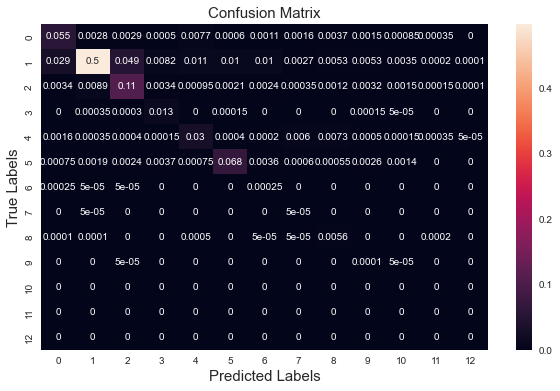

In [18]:
import seaborn as sns
matrix = confusion_matrix(y_pred, y_test, normalize='all')
plt.figure(figsize=(10, 6))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax)

# labels, title and ticks
ax.set_xlabel('Predicted Labels', size=15)
ax.set_ylabel('True Labels', size=15)
ax.set_title('Confusion Matrix', size=15)
# ax.xaxis.set_ticklabels([0,1], size=15)
# ax.yaxis.set_ticklabels([0,1], size=15)
;

# Logistic Regression

In [19]:
from sklearn.linear_model import LogisticRegression

In [20]:
clf = LogisticRegression(C=5, solver='liblinear').fit(X_train, y_train)

In [21]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
y_pred = clf.predict(X_test)
print("---Test Set Results---")
print("Accuracy with logreg: {}".format(accuracy_score(y_test, y_pred)))
print(classification_report(y_test, y_pred))

---Test Set Results---
Accuracy with logreg: 0.83705
              precision    recall  f1-score   support

           0       0.76      0.76      0.76      1820
           1       0.88      0.93      0.91     10246
           2       0.79      0.76      0.78      3203
           3       0.87      0.76      0.81       575
           4       0.72      0.74      0.73      1028
           5       0.87      0.92      0.89      1622
           6       0.61      0.49      0.55       361
           7       0.58      0.19      0.28       226
           8       0.75      0.68      0.71       470
           9       0.66      0.38      0.48       269
          10       0.46      0.08      0.14       150
          11       0.33      0.04      0.07        25
          12       0.00      0.00      0.00         5

    accuracy                           0.84     20000
   macro avg       0.64      0.52      0.55     20000
weighted avg       0.83      0.84      0.83     20000



/Users/utkarshgoyal/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/utkarshgoyal/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/utkarshgoyal/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

''

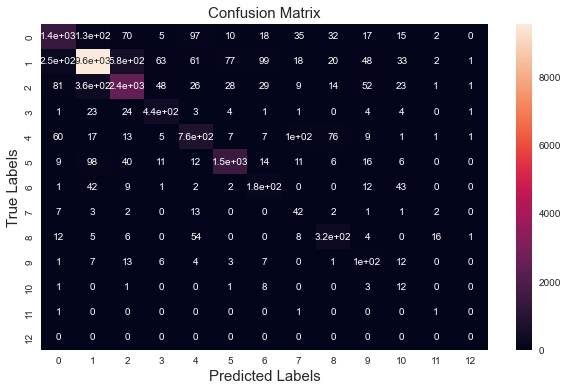

In [22]:
import seaborn as sns
matrix = confusion_matrix(y_pred, y_test)
plt.figure(figsize=(10, 6))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax)

# labels, title and ticks
ax.set_xlabel('Predicted Labels', size=15)
ax.set_ylabel('True Labels', size=15)
ax.set_title('Confusion Matrix', size=15)
# ax.xaxis.set_ticklabels([0,1], size=15)
# ax.yaxis.set_ticklabels([0,1], size=15)
;

# NN

In [23]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

from tensorflow.keras.preprocessing.text import Tokenizer

In [24]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/2")

In [25]:
X = df2['clean_review']
y = df2['category_id'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0, stratify=y)

In [26]:
vocab_size = 100000
embedding_dim = 64
max_length = 128
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'

In [27]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
hidden1 = tf.keras.layers.Dense(64, activation='sigmoid')(outputs['pooled_output'])
dropout1 = tf.keras.layers.Dropout(0.1, name="dropout")(hidden1)
hidden2 = tf.keras.layers.Dense(32, activation='sigmoid')(dropout1)
dropout2 = tf.keras.layers.Dropout(0.1, name="dropout2")(hidden2)
hidden3 = tf.keras.layers.Dense(16, activation='sigmoid')(dropout2)
l = tf.keras.layers.Dense(13, activation='softmax', name="output")(hidden3)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128)}                                                  

In [28]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2, restore_best_weights=True)
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [29]:
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), batch_size=100, shuffle=True, callbacks=[early_stop])

Epoch 1/50
750/750 [==============================] - 339s 449ms/step - loss: 1.5355 - accuracy: 0.5236 - val_loss: 1.3449 - val_accuracy: 0.5601
Epoch 2/50
750/750 [==============================] - 336s 448ms/step - loss: 1.3083 - accuracy: 0.5737 - val_loss: 1.2609 - val_accuracy: 0.5930
Epoch 3/50
750/750 [==============================] - 341s 455ms/step - loss: 1.2350 - accuracy: 0.6066 - val_loss: 1.1924 - val_accuracy: 0.6245
Epoch 4/50
750/750 [==============================] - 326s 435ms/step - loss: 1.1905 - accuracy: 0.6201 - val_loss: 1.1646 - val_accuracy: 0.6293
Epoch 5/50
750/750 [==============================] - 323s 431ms/step - loss: 1.1662 - accuracy: 0.6268 - val_loss: 1.1378 - val_accuracy: 0.6360
Epoch 6/50
750/750 [==============================] - 320s 427ms/step - loss: 1.1488 - accuracy: 0.6321 - val_loss: 1.1222 - val_accuracy: 0.6408
Epoch 7/50
750/750 [==============================] - 323s 430ms/step - loss: 1.1352 - accuracy: 0.6359 - val_loss: 1.1097 -

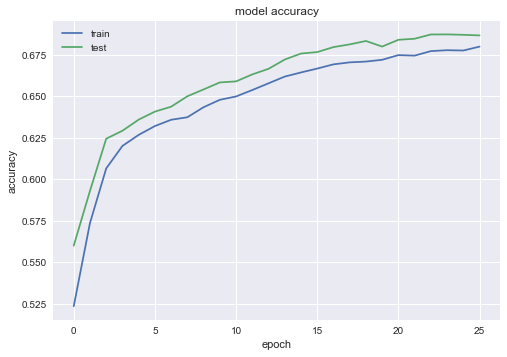

In [30]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

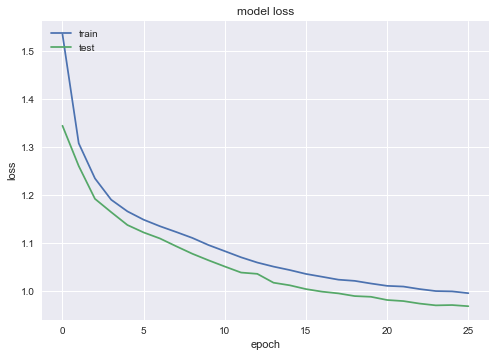

In [31]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [32]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
y_pred = model.predict(X_test)

782/782 [==============================] - 75s 95ms/step


In [33]:
y_predicted_labels = [np.argmax(i) for i in y_pred]

In [34]:
print("---Test Set Results---")
print("Accuracy with NN: {}".format(accuracy_score(y_test, y_predicted_labels)))

---Test Set Results---
Accuracy with NN: 0.68728


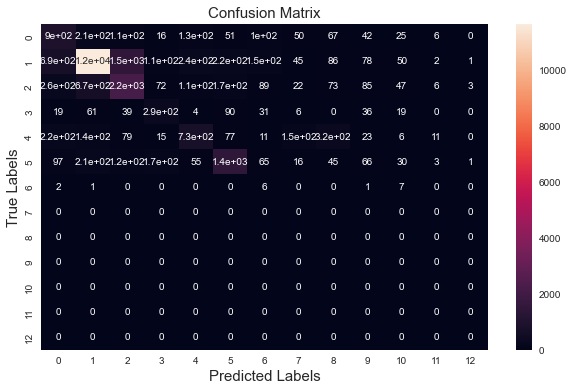

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
matrix = confusion_matrix(y_predicted_labels, y_test)
plt.figure(figsize=(10, 6))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax)

# labels, title and ticks
ax.set_xlabel('Predicted Labels', size=15)
ax.set_ylabel('True Labels', size=15)
ax.set_title('Confusion Matrix', size=15);

## LSTM

In [36]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
hidden1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim, return_sequences=True))(outputs['sequence_output'])
dropout1 = tf.keras.layers.Dropout(0.1, name="dropout")(hidden1)
hidden2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64))(dropout1)
dropout2 = tf.keras.layers.Dropout(0.1, name="dropout2")(hidden2)
hidden3 = tf.keras.layers.Dense(16, activation='sigmoid')(dropout2)
l = tf.keras.layers.Dense(13, activation='softmax', name="output")(hidden3)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128)}                                                

In [37]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2, restore_best_weights=True)
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [38]:
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), batch_size=100, shuffle=True, callbacks=[early_stop])

Epoch 1/50
750/750 [==============================] - 518s 685ms/step - loss: 1.3942 - accuracy: 0.5865 - val_loss: 1.0553 - val_accuracy: 0.6866
Epoch 2/50
750/750 [==============================] - 2422s 3s/step - loss: 0.9425 - accuracy: 0.7117 - val_loss: 0.8375 - val_accuracy: 0.7348
Epoch 3/50
750/750 [==============================] - 3126s 4s/step - loss: 0.7853 - accuracy: 0.7539 - val_loss: 0.7529 - val_accuracy: 0.7662
Epoch 4/50
750/750 [==============================] - 10166s 14s/step - loss: 0.7049 - accuracy: 0.7764 - val_loss: 0.7058 - val_accuracy: 0.7782
Epoch 5/50
750/750 [==============================] - 535s 713ms/step - loss: 0.6548 - accuracy: 0.7922 - val_loss: 0.6719 - val_accuracy: 0.7884
Epoch 6/50
750/750 [==============================] - 530s 707ms/step - loss: 0.6198 - accuracy: 0.8050 - val_loss: 0.6356 - val_accuracy: 0.7969
Epoch 7/50
750/750 [==============================] - 521s 695ms/step - loss: 0.5907 - accuracy: 0.8140 - val_loss: 0.6303 - val

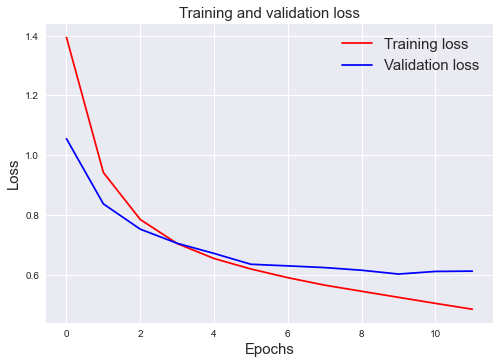

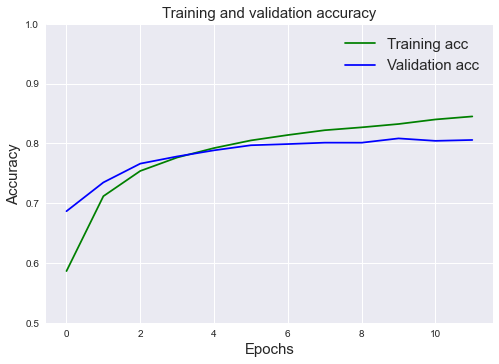

In [39]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = history.epoch

# plt.figure(figsize=(10,6))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss', size=15)
plt.xlabel('Epochs', size=15)
plt.ylabel('Loss', size=15)
plt.legend(prop={'size': 15})
plt.show()

# plt.figure(figsize=(10,6))
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy', size=15)
plt.xlabel('Epochs', size=15)
plt.ylabel('Accuracy', size=15)
plt.legend(prop={'size': 15})
plt.ylim((0.5,1))
plt.show()

In [ ]:
y_pred = model.predict(X_test)
y_predicted_labels = [np.argmax(i) for i in y_pred]

782/782 [==============================] - 104s 131ms/step


In [44]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
print("---Test Set Results---")
print("Accuracy with LSTM: {}".format(accuracy_score(y_test, y_predicted_labels)))
print(classification_report(y_test, y_predicted_labels))

---Test Set Results---
Accuracy with LSTM: 0.80836
              precision    recall  f1-score   support

           0       0.70      0.71      0.71      2185
           1       0.88      0.92      0.90     12947
           2       0.74      0.74      0.74      4024
           3       0.77      0.77      0.77       673
           4       0.62      0.71      0.66      1269
           5       0.84      0.86      0.85      2023
           6       0.50      0.44      0.47       455
           7       0.00      0.00      0.00       286
           8       0.62      0.54      0.58       590
           9       0.43      0.25      0.32       331
          10       0.00      0.00      0.00       184
          11       0.00      0.00      0.00        28
          12       0.00      0.00      0.00         5

    accuracy                           0.81     25000
   macro avg       0.47      0.46      0.46     25000
weighted avg       0.79      0.81      0.80     25000



/Users/utkarshgoyal/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/utkarshgoyal/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/utkarshgoyal/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

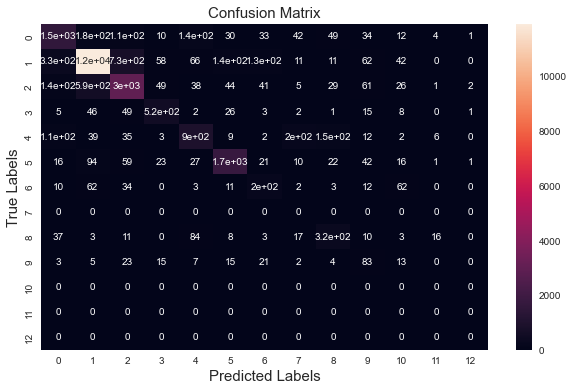

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
matrix = confusion_matrix(y_predicted_labels, y_test)
plt.figure(figsize=(10, 6))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax)

# labels, title and ticks
ax.set_xlabel('Predicted Labels', size=15)
ax.set_ylabel('True Labels', size=15)
ax.set_title('Confusion Matrix', size=15);